# Applied Data Analysis: Movies
This project analyzes the key factors influencing box-office success for films released between 1915 and 2015, seeking to understand how audience preferences and industry trends have evolved over time.

We will work with three datasets:
- CMU Movie Summary
- IMDb dataset
- CPI (Consumer Price Index of US Bureau of Labor Statistics)

## Loading the Datasets

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
import os
import sys
import plotly.graph_objects as go
import statsmodels.api as sm
import plotly.express as px
import plotly.io as pio

from importlib import reload
import src.utils.utils
reload(src.utils.utils)
from src.utils.utils import top_n_by_interval, top_n_total_revenue, top_n_average_rating

In [2]:
data_folder = './data/'
pickle_folder = data_folder + 'pickle/'
imdb_folder = data_folder + 'IMDB/'
cmu_folder = data_folder + 'CMU/'

# 2. Feature Importance Analysis

In [14]:
import statsmodels.api as sm
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


# fix random seed for reproducibility
np.random.seed(42)
random.seed(42)

## Training model on complete dataframe without seasons

In [15]:
with open(pickle_folder+"movies_clean.p", 'rb') as f:
    movies_clean = pickle.load(f)
with open(pickle_folder+"characters_clean.p", 'rb') as f:
    characters_clean = pickle.load(f)

In [16]:
periods = sorted(movies_clean["Year_Interval"].unique())
periods

['1915-1930', '1930-1950', '1950-1970', '1970-2000', '2000-2015']

In [60]:
def top_10_(df,feature):
    # top 30 rated movies
    top30_ = df.sort_values(by="averageRating",ascending=False).head(30)
    
    top10 = top30_[[x for x in top30_.columns if x.startswith(feature)]].sum(axis=0).sort_values(ascending=False).head(10)
    return top10

In [61]:
def corr_matrix_top_(period,df,feature):
    top_ = top_10_(df,feature)
    
    correlation_matrix=top_[[x for x in top_.columns if x.startswith(feature)]].corr().dropna(how='all').dropna(axis=1,how='all')
    print(correlation_matrix.shape)
    # Optionally, you can visualize the correlation matrix using a heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix of {feature} in {period}')
    plt.show()

In [62]:
def plot_feature_importance(period,df,feature):
    # Define features and target
    X = df[[x for x in df.columns if x.startswith(feature)]]
    y = df['averageRating']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train an XGBoost model
    xgb = XGBRegressor(random_state=42)
    xgb.fit(X_train, y_train)
    
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb.feature_importances_}).sort_values(by='Importance', ascending=False)
    
    # Plot the feature importance for the model
    plt.figure(figsize=(10, 15))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.title(f'{feature} Importance in {period}')
    plt.xlabel('Importance')
    plt.ylabel(f'{feature}')
    plt.show()

In [63]:
def plot_mean_per_year_(period,df,feature):
    mean_age_per_year = df.groupby('Year')[feature].mean()
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(mean_age_per_year.index, mean_age_per_year.values, marker='o', linestyle='-', color='b', label=f'Mean {feature}')
    plt.title(f'Mean {feature} ({period})', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(f'Mean {feature}', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# 1915 - 1930 (Silent Films)

In [64]:
period0 = periods[0]
df_period0 = movies_clean[movies_clean["Year_Interval"] == period0]

1.7493333333333334

1.1204819277108433

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_48229/447326171.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



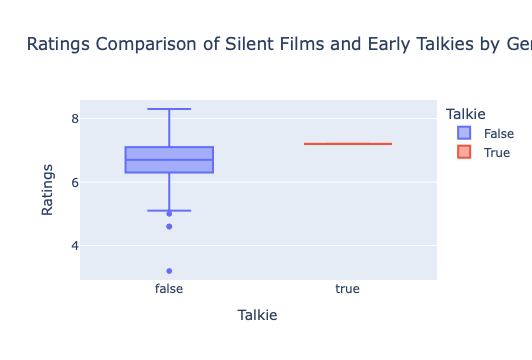

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import plotly.express as px
from sklearn.model_selection import train_test_split

# Step 1: Define which films are silent films and which are early talkies
# We assume you have a column 'Talkie' where 1 = early talkie and 0 = silent film.

df = df_period0.copy()

display(df[df['Genre_Silent film']==True].nb_of_Languages.mean())

df['Talkie'] = ~df['Genre_Silent film']

display(df[df['Talkie']==True].nb_of_Languages.mean())


# Define a subset of the data (example: genres and talkie status)
df_subset = df[['averageRating', 'Talkie'] + [x for x in df.columns if x.startswith("Genre_")]]

# Step 2: Propensity Score Estimation
# We will estimate the propensity scores for being an early talkie, using logistic regression.

X = df_subset[[x for x in df.columns if x.startswith("Genre_")]]  # Use genres as features
y = df_subset['Talkie']  # Target: Talkie (1 for early talkie, 0 for silent film)

# Fit a logistic regression model to estimate propensity scores
model = LogisticRegression(solver='liblinear')
model.fit(X, y)

# Propensity scores: The probability that each film is a talkie (vs. silent)
df_subset['Propensity_Score'] = model.predict_proba(X)[:, 1]

# Step 3: Matching based on propensity scores
# Use nearest neighbors to find matched pairs of silent films and talkies based on their propensity scores.

# Separate the data into silent films and early talkies
silent_films = df_subset[df_subset['Talkie'] == 0]
talkies = df_subset[df_subset['Talkie'] == 1]

# Fit a nearest neighbors model on the propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(talkies[['Propensity_Score']])

# For each silent film, find the closest early talkie (based on propensity score)
distances, indices = nn.kneighbors(silent_films[['Propensity_Score']])

# Get the matched early talkies
matched_talkies = talkies.iloc[indices.flatten()]

# Step 4: Combine the matched data (silent films and matched talkies)
matched_data = pd.concat([silent_films, matched_talkies])

# Step 5: Plot the box plot for ratings comparison within genres
# We will focus on a key genre (e.g., 'Genre_1') for visualization.

# For simplicity, let's assume you're interested in 'Genre_1'
matched_data['Genre_Silent film'] = matched_data[f'Genre_Silent film']

# Box plot by genre
fig = px.box(
    matched_data,
    x='Talkie',  # 0 for silent films, 1 for early talkies
    y='averageRating',
    color='Talkie',
    category_orders={'Talkie': [0, 1]},  # Order silent films first
    labels={'Talkie': 'Talkie', 'averageRating': 'Ratings'},
    title='Ratings Comparison of Silent Films and Early Talkies by Genre'
)

# Show the plot
fig.show()


Top 10 most frequent Countries in the 30 highest-rated movies :


Country_United States of America    20
Country_Other                        8
Country_Germany                      7
Country_France                       1
Country_Argentina                    0
Country_Canada                       0
Country_Hong Kong                    0
Country_India                        0
Country_Italy                        0
Country_Japan                        0
dtype: int64

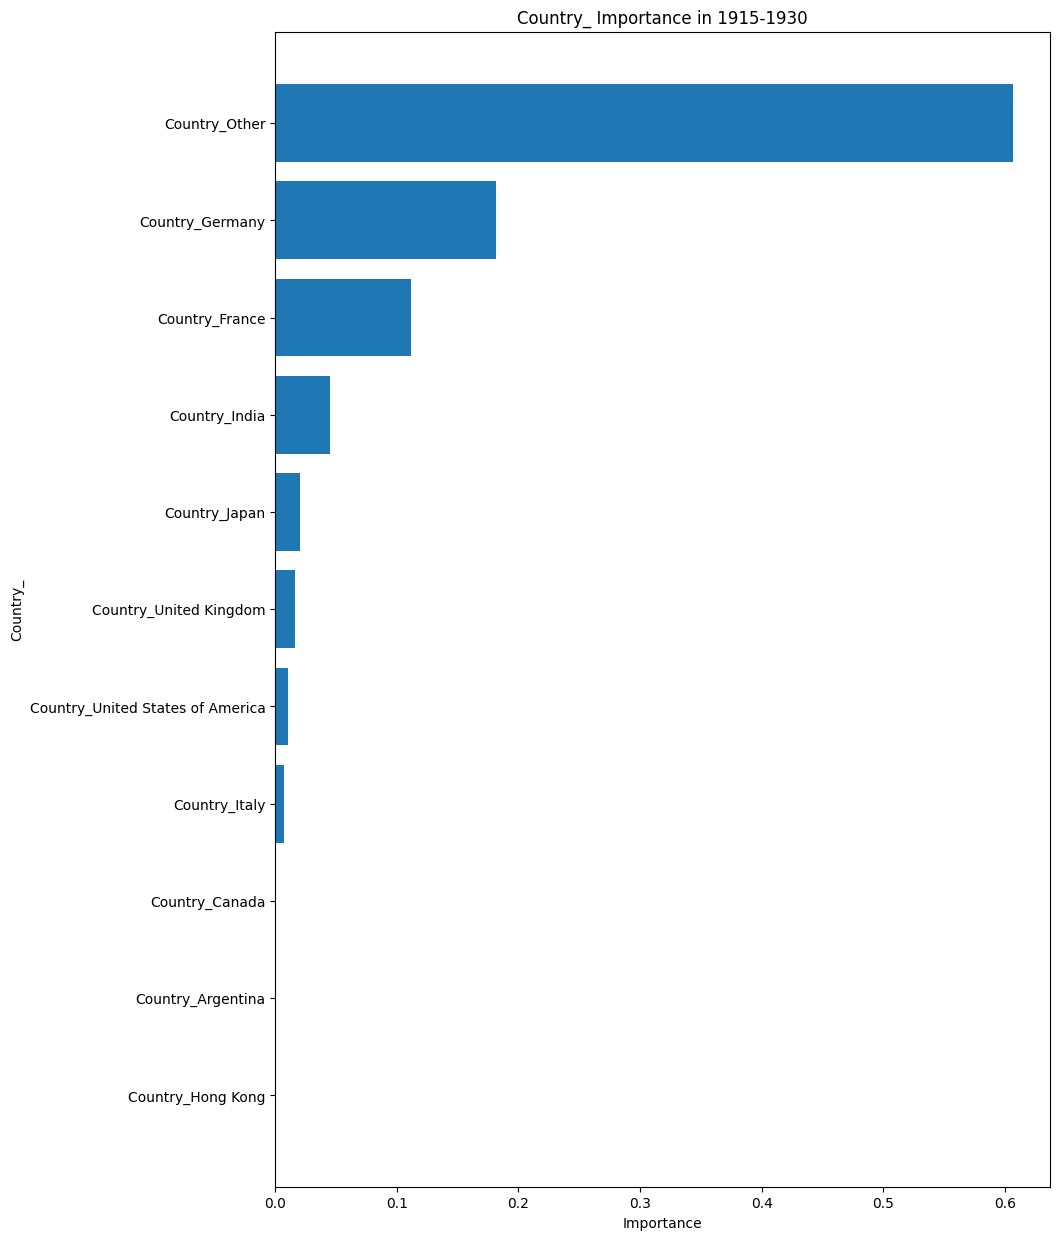

In [66]:
# USA dominates the production of movies at that period (emergence of Hollywood), however in the late 20's, 
# the apparition of talkies also allowed the beginning of cinematic movement in the world, like the German 
# Expressionism

print("Top 10 most frequent Countries in the 30 highest-rated movies :")
display(top_10_(df_period0,'Country_'))
plot_feature_importance(period0,df_period0,'Country_')

Top 10 most frequent Languages in the 30 highest-rated movies :



lang_silent film          24
lang_english              20
lang_german                7
lang_other                 3
lang_french                2
lang_hindi                 0
lang_italian               0
lang_japanese              0
lang_spanish               0
lang_standard mandarin     0
dtype: int64

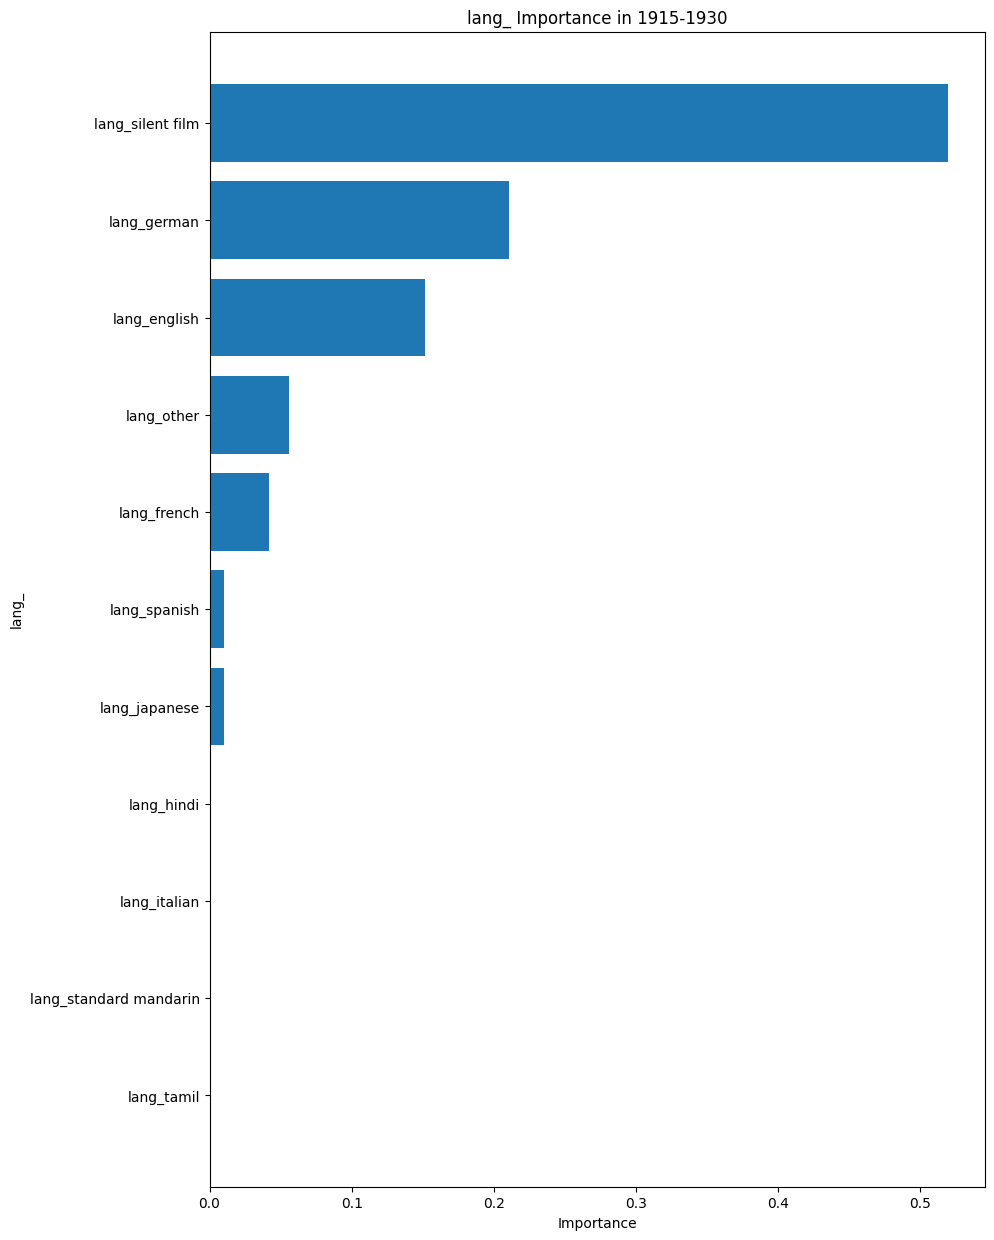

count    30.000000
mean      1.133333
std       0.345746
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: nb_of_Languages, dtype: float64

On average, each movie is available in only one language, and very few films are translated.


In [92]:
# Language Feature is not interesting to study for that period, because it is largely dominated by silent 
# films. Concerning the late 20's, when the "talkies" emerges, the language feature is really similar 
# to Country because each country produces its own film and not much translations are done.

print("Top 10 most frequent Languages in the 30 highest-rated movies :\n")
display(top_10_(df_period0,'lang_'))
plot_feature_importance(period0,df_period0,'lang_')
display(df_period0.sort_values("averageRating").head(30)["nb_of_Languages"].describe())
print("On average, each movie is available in only one language, and very few films are translated.")

Age_Interval
Experimented Actor(30-60)    1171
Young Actor(19-30)            746
Old Actor(60+)                 99
Teenager(13-19)                93
Kid(3-13)                      32
Baby(0-3)                       4
Name: count, dtype: int64

35.988013698630134

Age_Interval
Experimented Actor(30-60)    1171
Young Actor(19-30)            746
Old Actor(60+)                 99
Teenager(13-19)                93
Kid(3-13)                      32
Baby(0-3)                       4
Name: count, dtype: int64

Actor_gender
M    1400
F     744
Name: count, dtype: int64

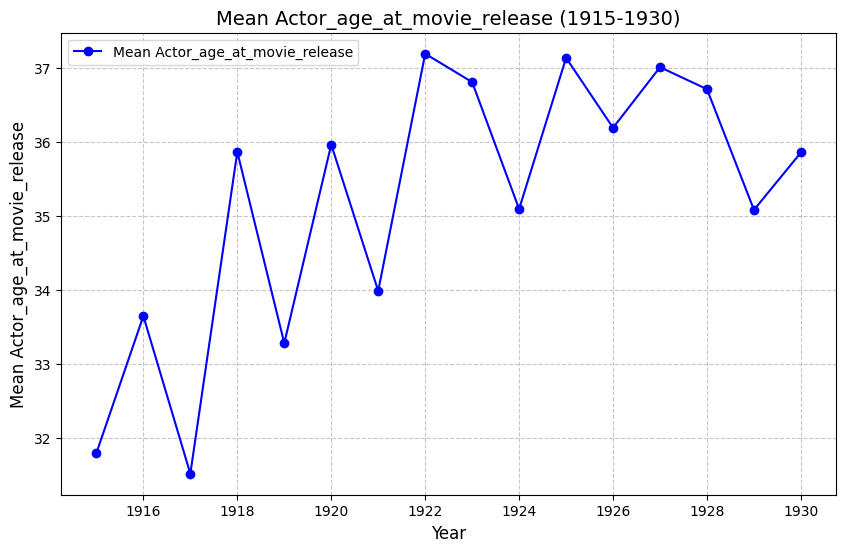

In [68]:
# When comparing the evolution of the mean_Age on the period, we notice the increase of the mean.
# The introduction of sound in films required actors with strong vocal skills and the ability to deliver 
# lines effectively. Many experienced actors from the silent era, who were already in their mid-30s, 
# transitioned into talkies, leading to an increase in the average age.
df_char0 = characters_clean[characters_clean["Year_Interval"]==period0]
display(df_char0.sort_values("averageRating")['Age_Interval'].value_counts())
display(df_char0[df_char0['Year']>1926].sort_values("averageRating").groupby("Wikipedia_movie_ID").head(30).apply(lambda x:x)['Actor_age_at_movie_release'].mean())


display(df_char0['Age_Interval'].value_counts())
display(df_char0['Actor_gender'].value_counts())

plot_mean_per_year_(period0,df_char0,'Actor_age_at_movie_release')

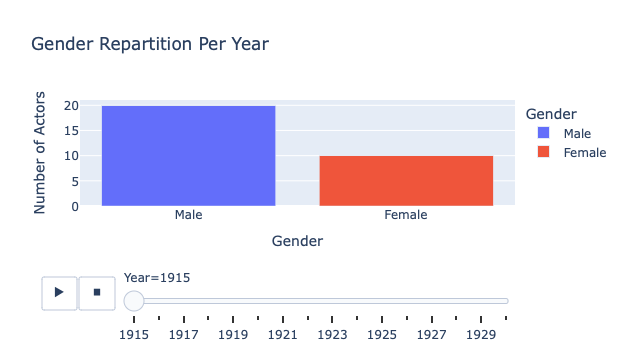

In [69]:
import plotly.express as px

count = df_char0.groupby('Year').apply(lambda x: x['Actor_gender'].value_counts(),include_groups=False).reset_index()

df_long = count.melt(id_vars='Year', 
                  value_vars=['M', 'F'], 
                  var_name='gender', 
                  value_name='count')

df_long['gender'] = df_long['gender'].replace({'M': 'Male', 'F': 'Female'})

# Create a bar chart with a slider
fig = px.bar(
    df_long,
    x='gender',
    y='count',
    color='gender',
    animation_frame='Year',  # Slider is automatically created based on the 'year'
    title='Gender Repartition Per Year',
    labels={'count': 'Number of Actors', 'gender': 'Gender'},
)

# Update layout for better visuals
fig.update_layout(
    xaxis_title="Gender",
    yaxis_title="Number of Actors",
    legend_title="Gender",
    transition={'duration': 500},  # Smooth transitions
)

# Show the plot
fig.show()

Globally, there are twice as much Male actors than Female actors

# 1930-1950 (Studio Glory)

In [70]:
period1 = periods[1]
df_period1 = movies_clean[movies_clean["Year_Interval"] == period1]
df_period1.shape

(3259, 61)

Top 10 most frequent genres in the 30 highest-rated movies :


Genre_Drama              28
Genre_Black-and-white    23
Genre_Noir               10
Genre_Romance             8
Genre_Comedy              7
Genre_Crime               7
Genre_Historical          7
Genre_World cinema        6
Genre_War                 5
Genre_Thriller            5
dtype: int64

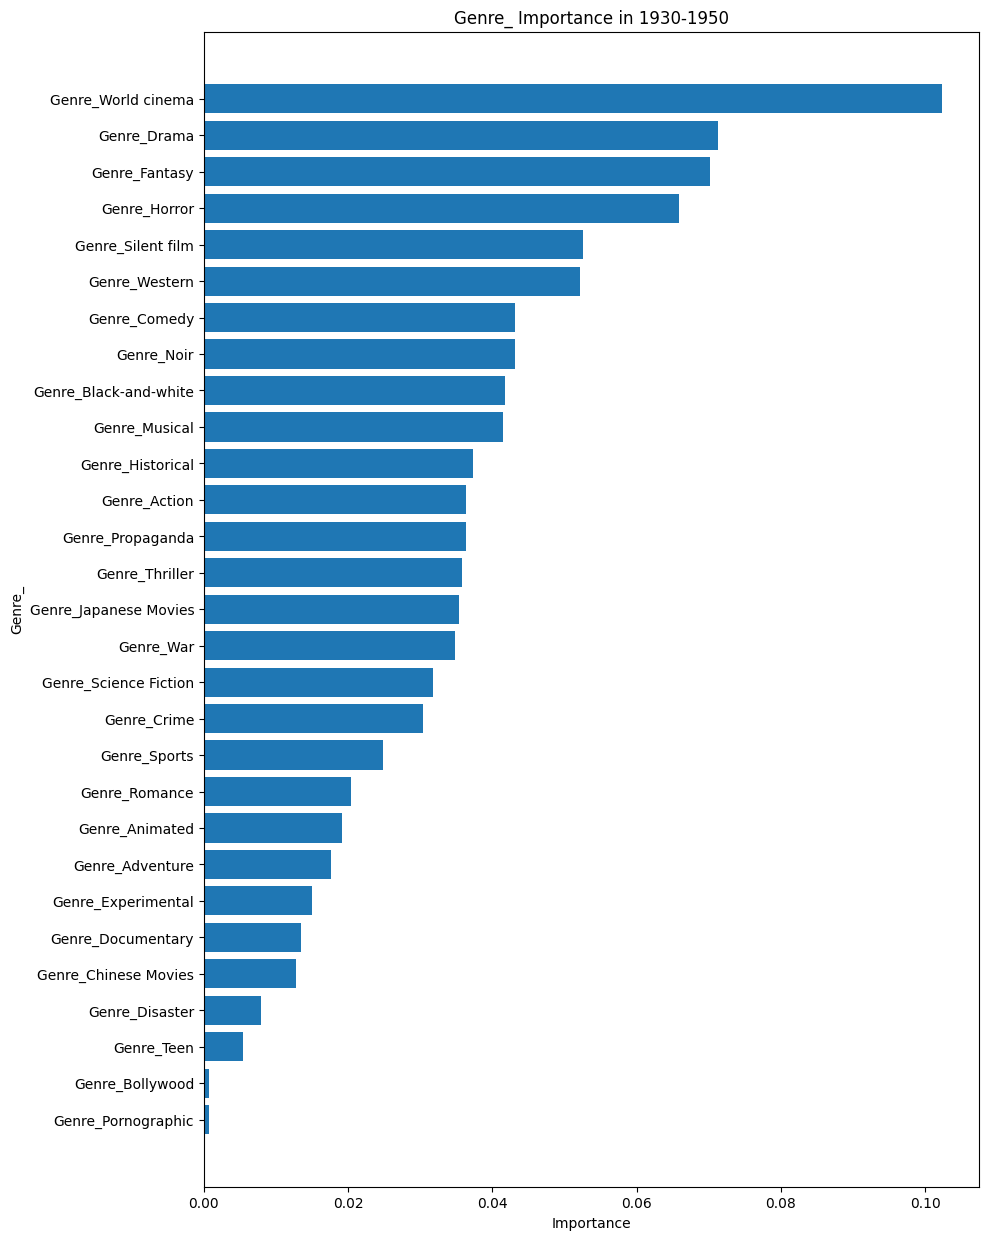

nb_of_Genres stats for 1930-1950 :



count    3259.000000
mean        3.780608
std         1.970947
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        11.000000
Name: nb_of_Genres, dtype: float64


nb_of_Genres stats for 1915-1930 :



count    541.000000
mean       4.364140
std        2.130582
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       14.000000
Name: nb_of_Genres, dtype: float64

In [74]:
# We notice a light decrease of the number of genres per film, as well as the 

print("Top 10 most frequent genres in the 30 highest-rated movies :")
display(top_10_(df_period1,'Genre_'))
plot_feature_importance(period1,df_period1,'Genre_')
print(f"nb_of_Genres stats for {period1} :\n")
display(df_period1['nb_of_Genres'].describe())
print(f"\nnb_of_Genres stats for {period0} :\n")
display(df_period0['nb_of_Genres'].describe())

Top 10 most productive contries in the 30 highest-rated movies :


Country_United States of America    22
Country_Other                        3
Country_France                       2
Country_Japan                        2
Country_Germany                      1
Country_Italy                        1
Country_United Kingdom               1
Country_Argentina                    0
Country_Canada                       0
Country_Hong Kong                    0
dtype: int64

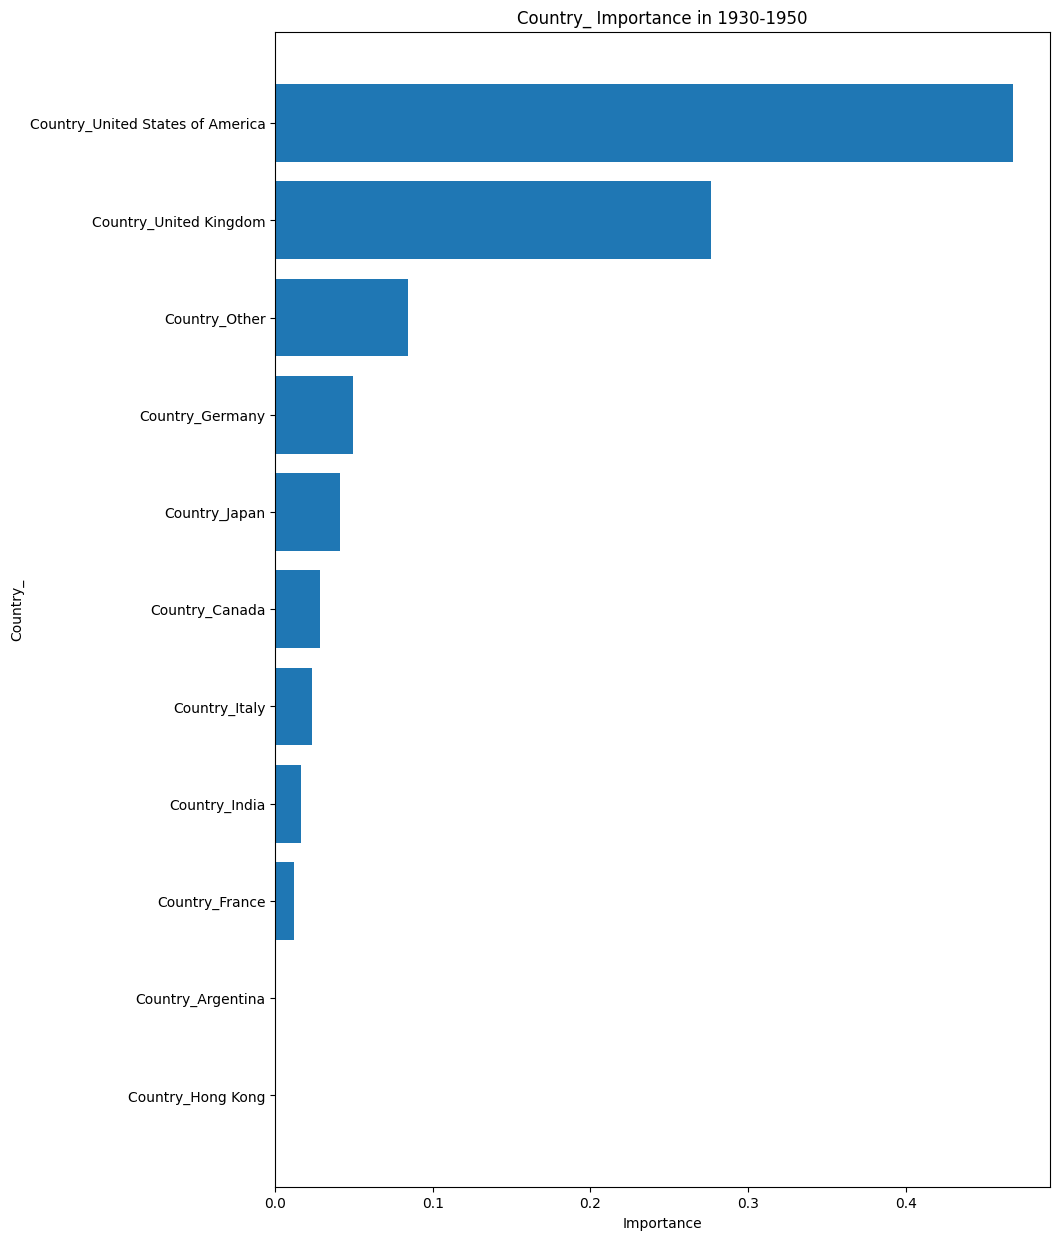

In [75]:
# OverDominance of Hollywood oon the other countries : it's Hollywood Golden Age !

print("Top 10 most productive contries in the 30 highest-rated movies :")
display(top_10_(df_period1,'Country'))
plot_feature_importance(period1,df_period1,'Country_')

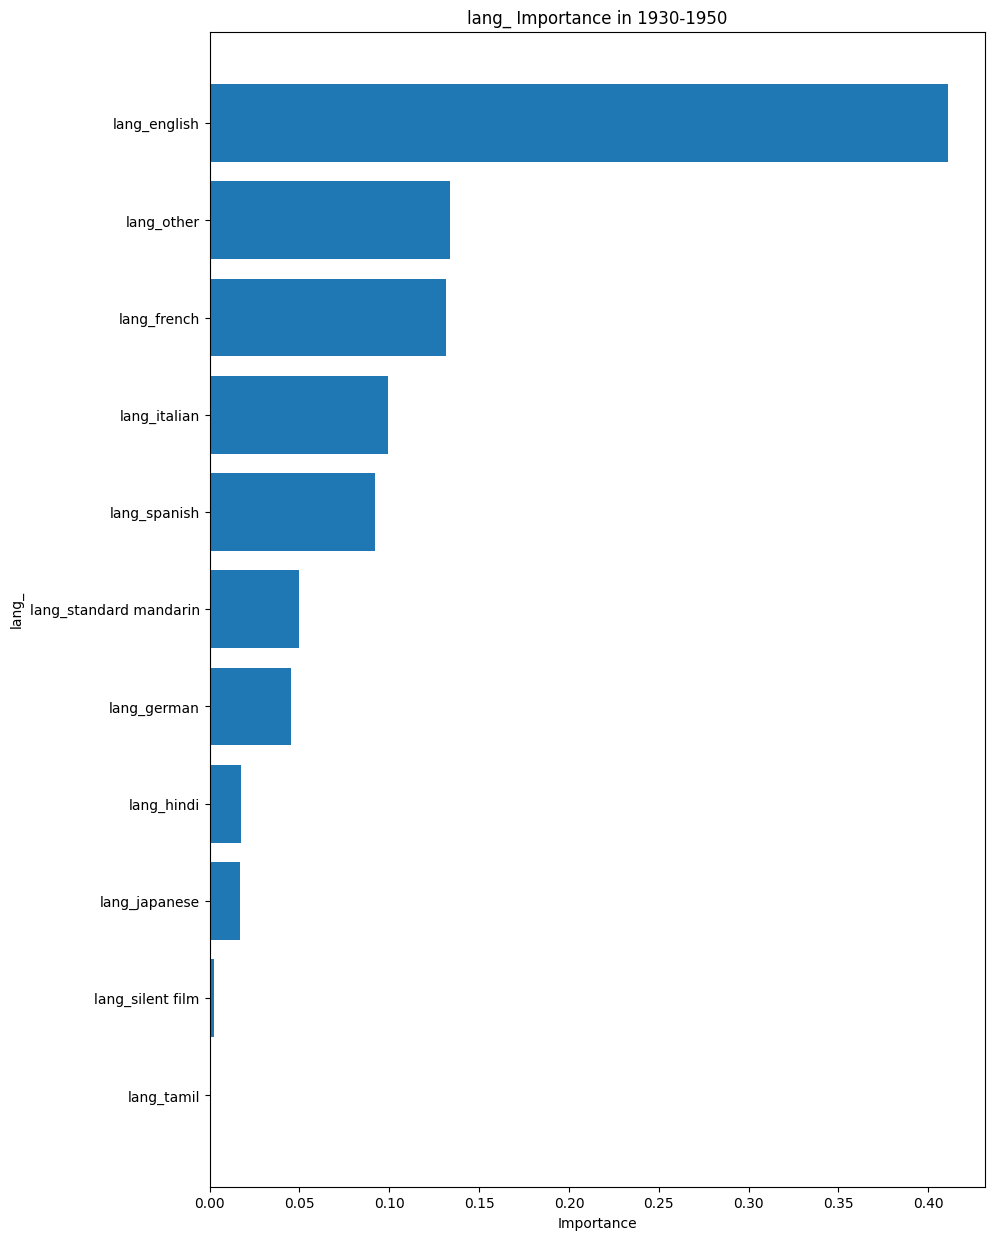

count    30.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: nb_of_Languages, dtype: float64

In [93]:
# Whereas English is still the most important language in the cinema world, we noticed the emergence of 
# other languages as french, italian or spanish. We also noticed the quick disparition of the silent films.

plot_feature_importance(period1,df_period1,'lang_')
display(df_period1.sort_values(by="averageRating").head(30)["nb_of_Languages"].describe())

Actor_gender
M    9254
F    4379
Name: count, dtype: int64

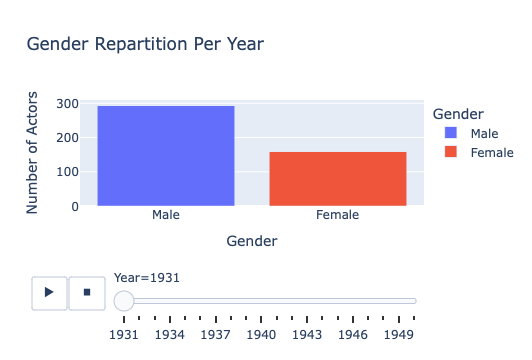

In [77]:
import plotly.express as px

df_char1 = characters_clean[characters_clean["Year_Interval"]==period1]
display(df_char1['Actor_gender'].value_counts())

count = df_char1.groupby('Year').apply(lambda x: x['Actor_gender'].value_counts(),include_groups=False).reset_index()

df_long = count.melt(id_vars='Year', 
                  value_vars=['M', 'F'], 
                  var_name='gender', 
                  value_name='count')

df_long['gender'] = df_long['gender'].replace({'M': 'Male', 'F': 'Female'})

# Create a bar chart with a slider
fig = px.bar(
    df_long,
    x='gender',
    y='count',
    color='gender',
    animation_frame='Year',  # Slider is automatically created based on the 'year'
    title='Gender Repartition Per Year',
    labels={'count': 'Number of Actors', 'gender': 'Gender'},
)

# Update layout for better visuals
fig.update_layout(
    xaxis_title="Gender",
    yaxis_title="Number of Actors",
    legend_title="Gender",
    transition={'duration': 500},  # Smooth transitions
)

# Show the plot
fig.show()

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_48229/2661389008.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



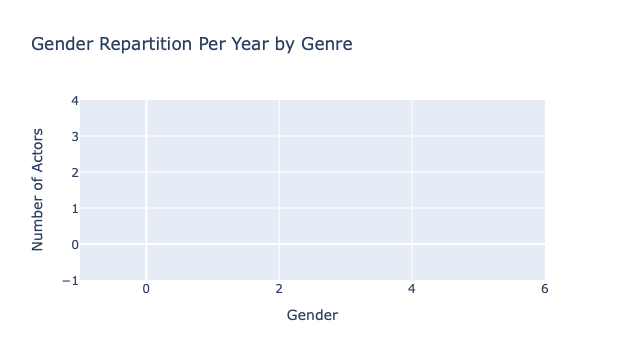

In [78]:
genre_columns = [col for col in df_char1.columns if col.startswith('Genre_')]

# Group by Year and Gender, counting the number of male and female actors per genre
# We'll first create a new column that stores the sum of genres per row for each actor
df_char1['Genre_count'] = df_char1[genre_columns].sum(axis=1)

# Group by Year and Gender and get the count of actors per genre
count = df_char1.groupby(['Year', 'Actor_gender'])[genre_columns].sum().reset_index()

# Melt the DataFrame to long format for easier plotting
df_long = count.melt(id_vars=['Year', 'Actor_gender'], 
                     value_vars=genre_columns, 
                     var_name='Genre', 
                     value_name='count')

# Replace 'M' and 'F' with 'Male' and 'Female' for readability
df_long['Actor_gender'] = df_long['Actor_gender'].replace({'M': 'Male', 'F': 'Female'})

# Filter out rows where count is 0 (no actors in that genre for that year/gender)
df_long = df_long[df_long['count'] > 0]

# Create a bar chart with a slider for both Year and Genre
fig = px.bar(
    df_long,
    x='Actor_gender',
    y='count',
    color='Actor_gender',
    animation_frame='Year',  # Slider is based on 'Year'
    animation_group='Genre',  # This groups the bars by 'Genre'
    facet_col='Genre',  # Create separate subplots by Genre
    title='Gender Repartition Per Year by Genre',
    labels={'count': 'Number of Actors', 'Actor_gender': 'Gender'},
)

# Update layout for better visuals
fig.update_layout(
    xaxis_title="Gender",
    yaxis_title="Number of Actors",
    legend_title="Gender",
    transition={'duration': 500},  # Smooth transitions
)

# Show the plot
fig.show()

# 1950-1970 (Auteur Rise)

In [79]:
df_period2 = movies_clean[movies_clean["Year_Interval"] == periods[2]]
df_period2.shape

(3983, 61)

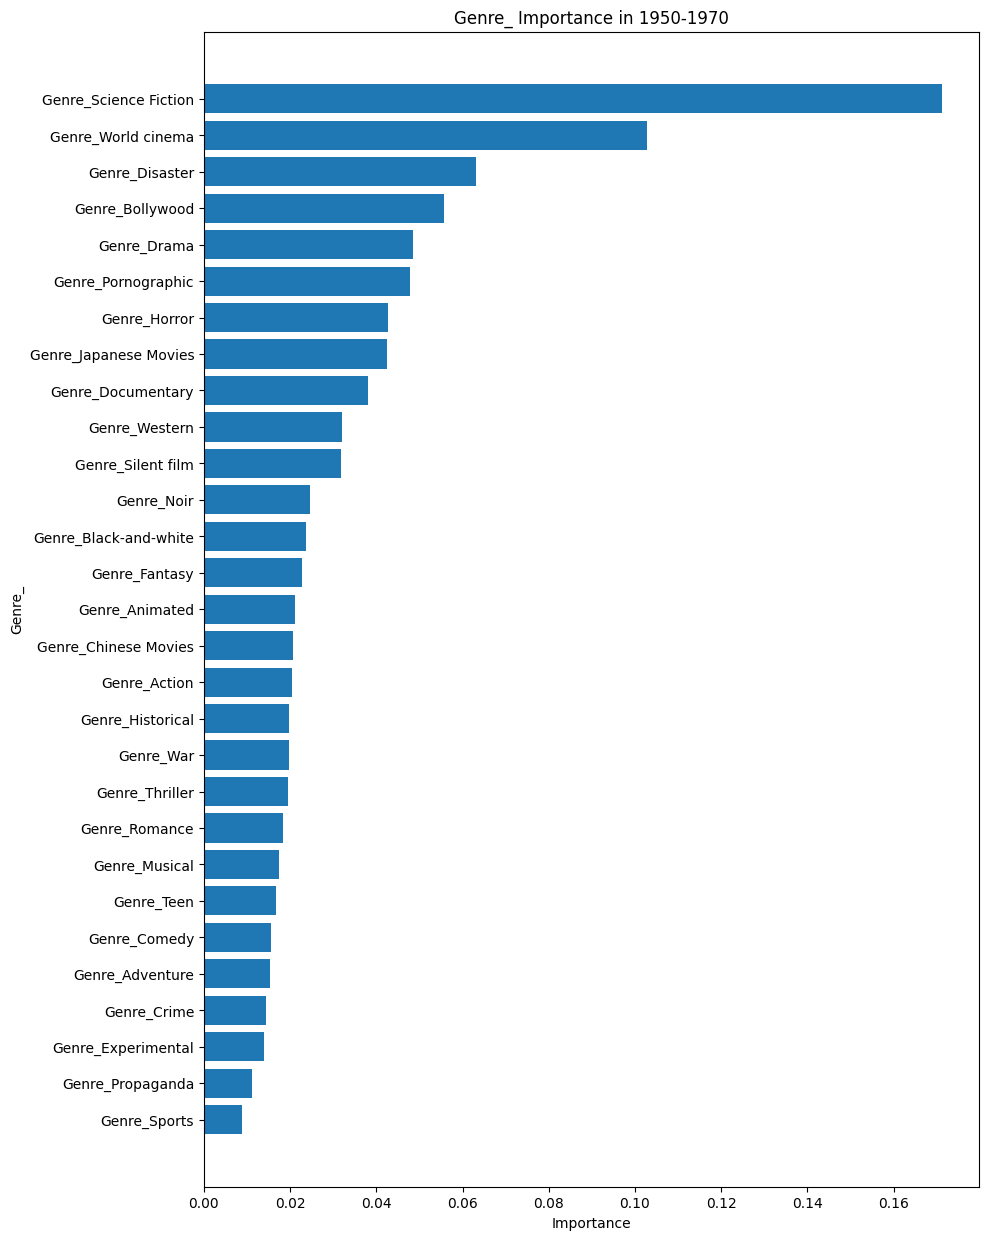

In [81]:
plot_feature_importance('1950-1970',df_period2,'Genre_')

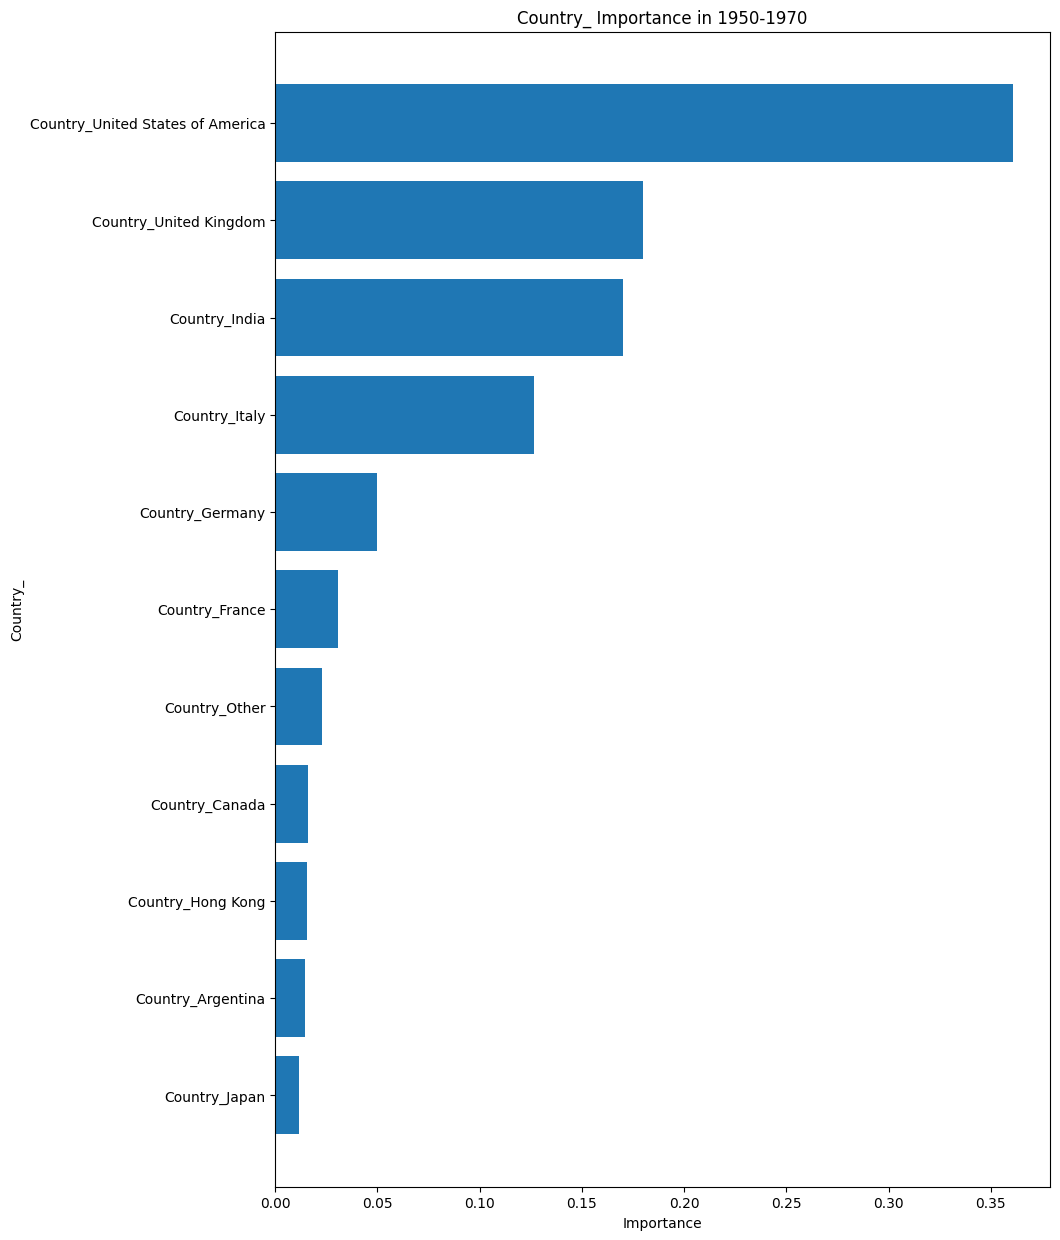

In [83]:
plot_feature_importance('1950-1970',df_period2,'Country_')

# 1970 - 2000 (Global Blockbusters)

In [58]:
df_period3 = movies_clean[movies_clean["Year_Interval"] == periods[3]]
df_period3.shape

(9227, 61)

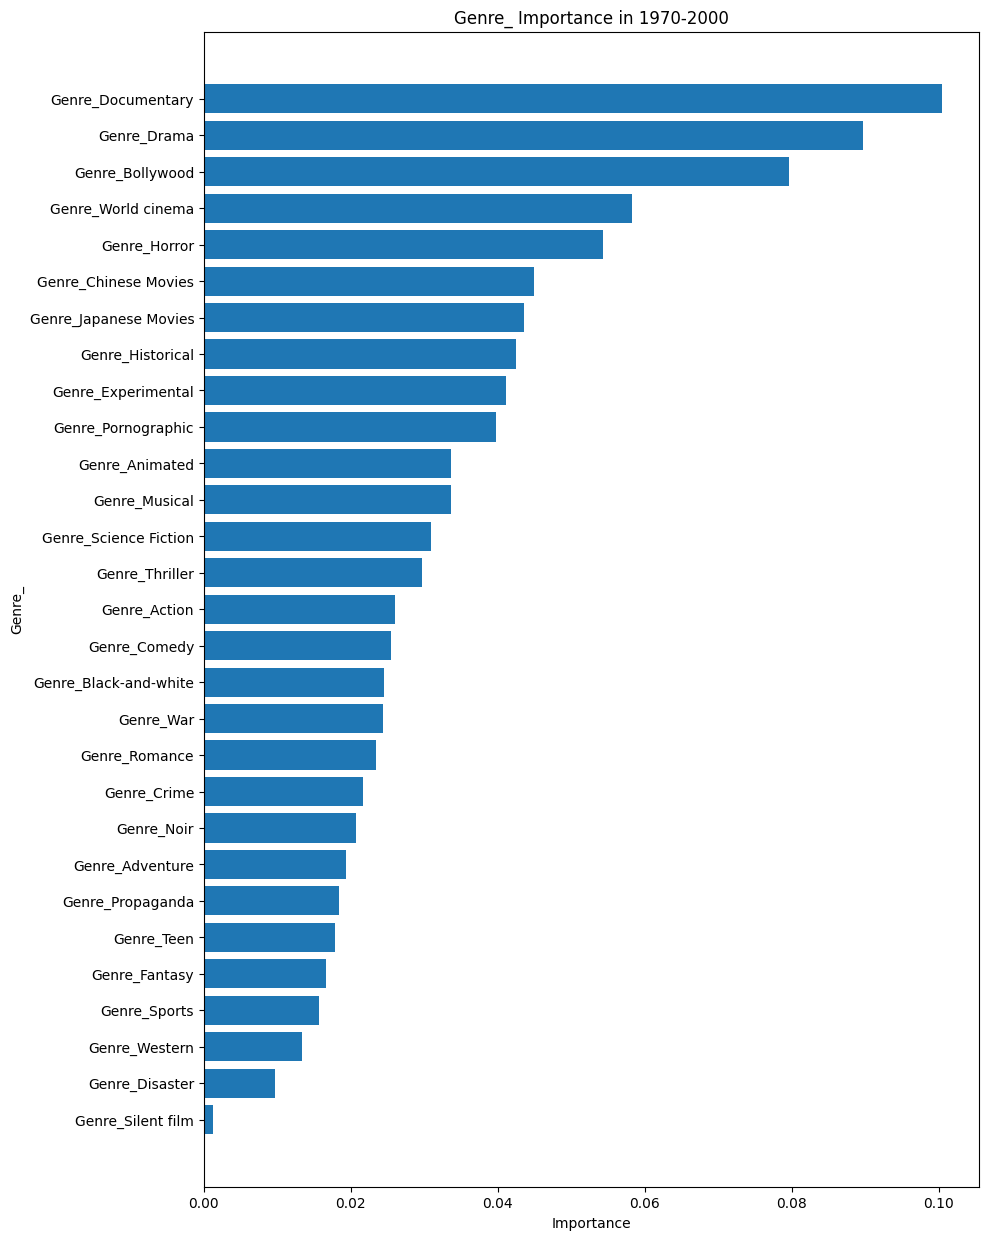

In [84]:
plot_feature_importance('1970-2000',df_period3,'Genre_')

(7, 7)


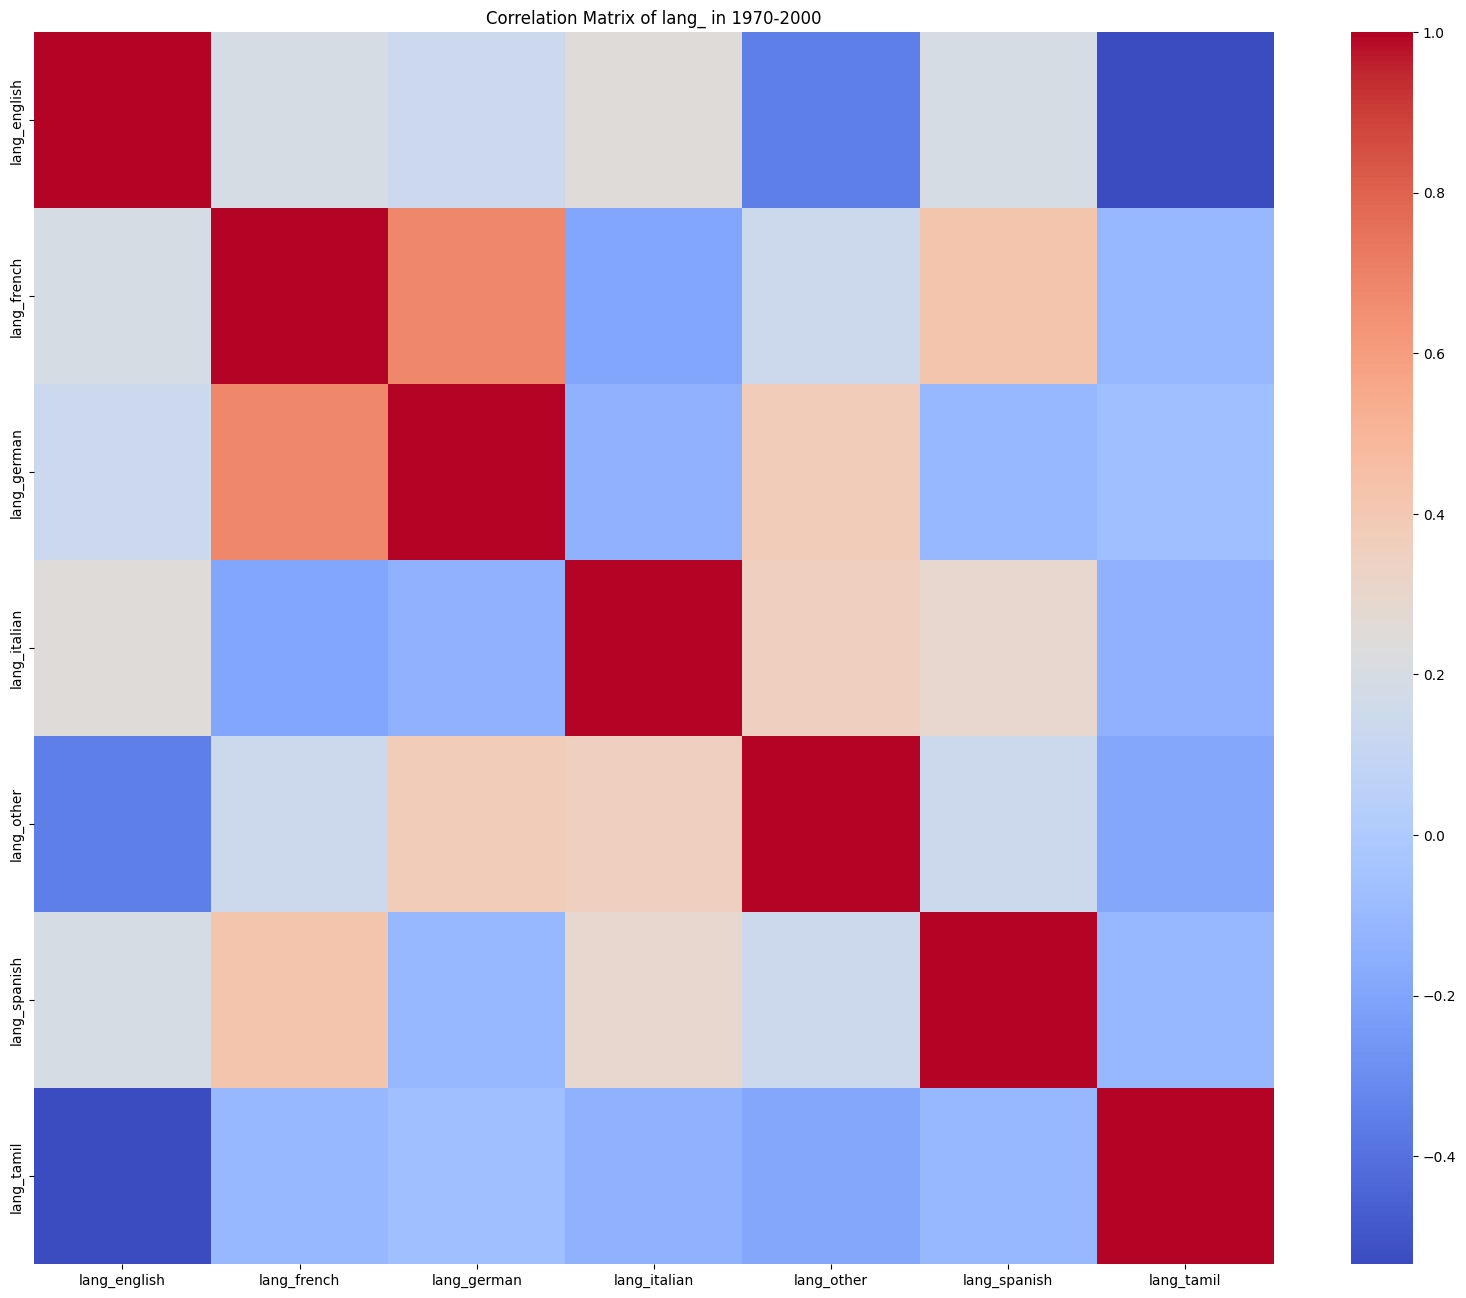

In [522]:
corr_matrix_top_(periods[3],df_period3,"lang_")

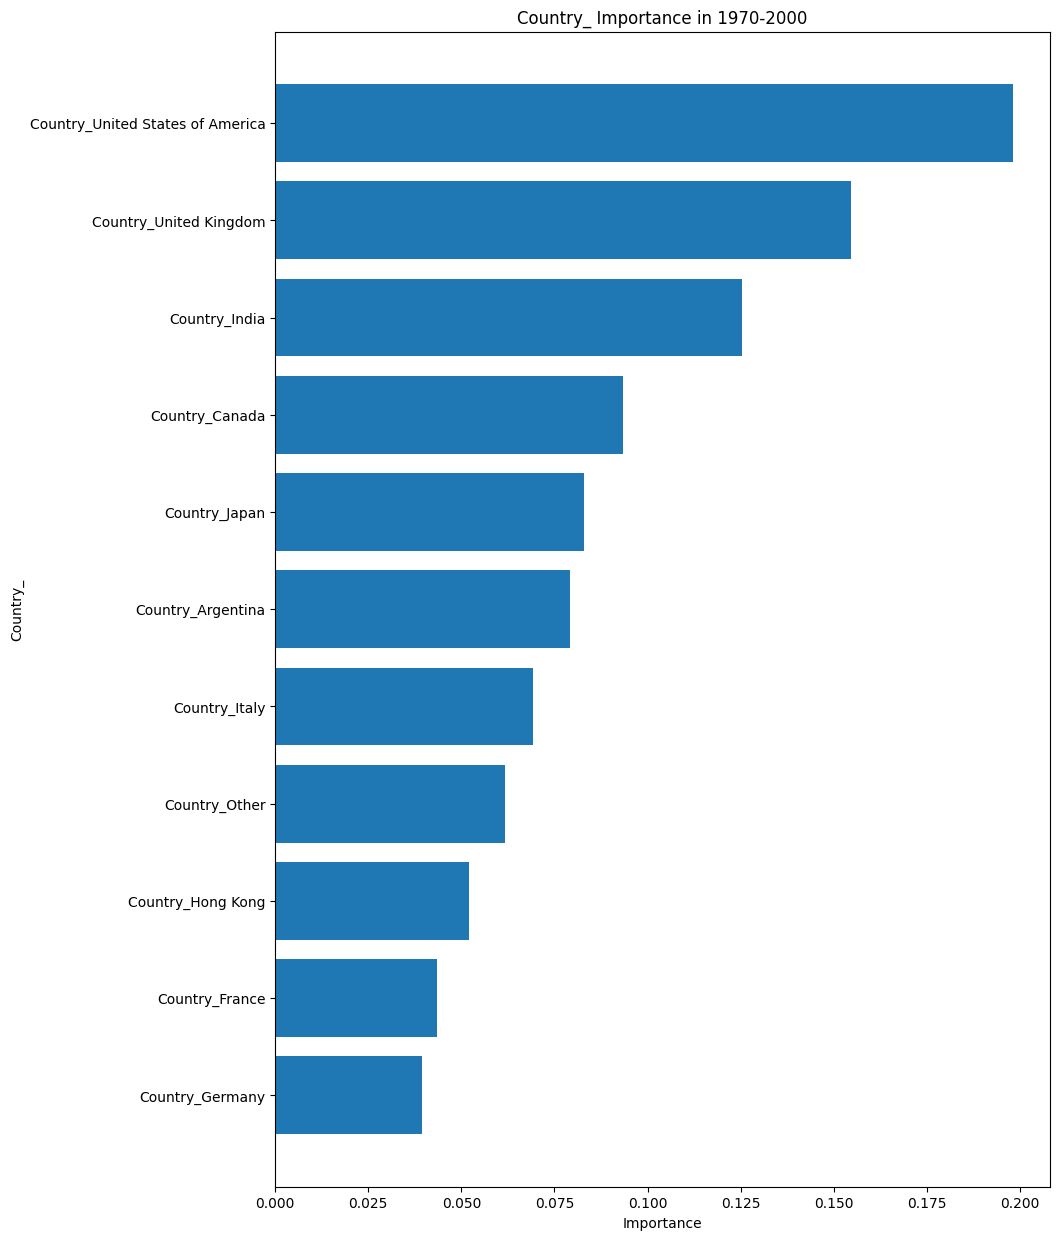

(4, 4)


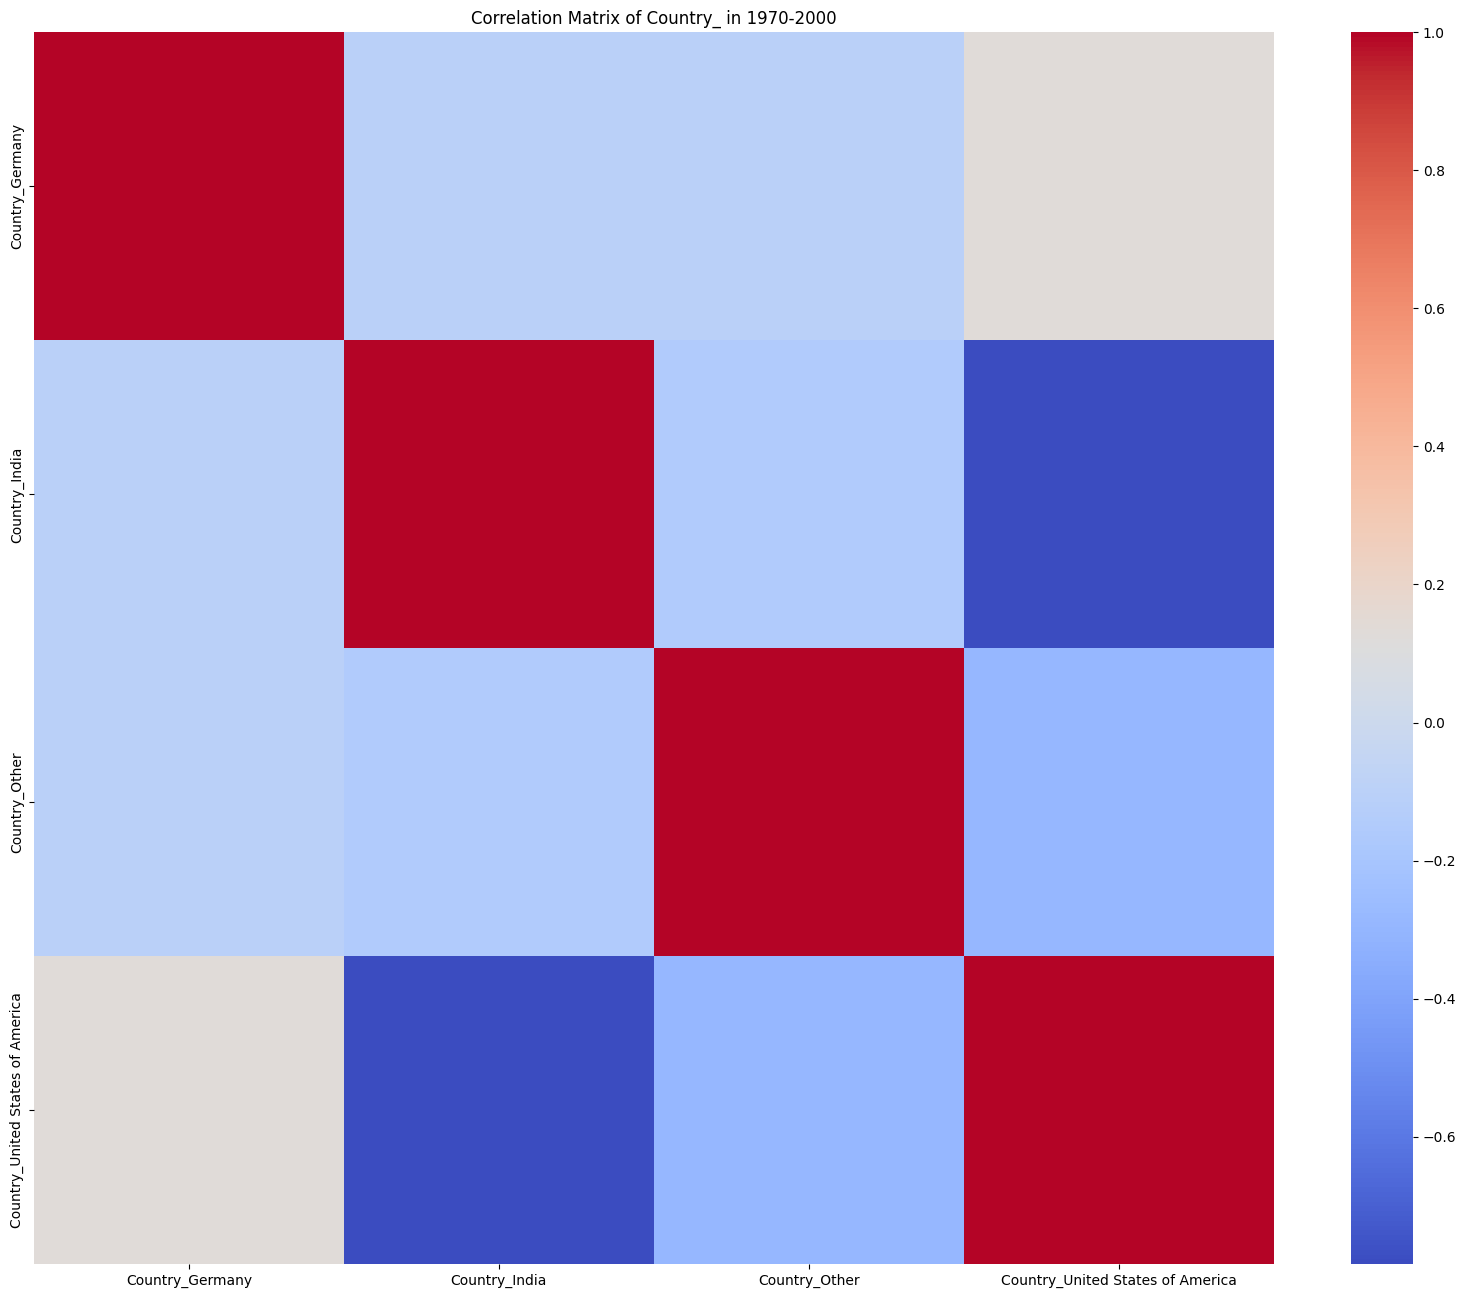

In [523]:
plot_feature_importance('1970-2000',df_period3,'Country_')
corr_matrix_top_(periods[3],df_period3,"Country_")

# 2000 - 2015 (Digital Diversity)

In [569]:
df_period4 = movies_clean[movies_clean["Year_Interval"] == periods[4]]
df_period4.shape

(8174, 73)

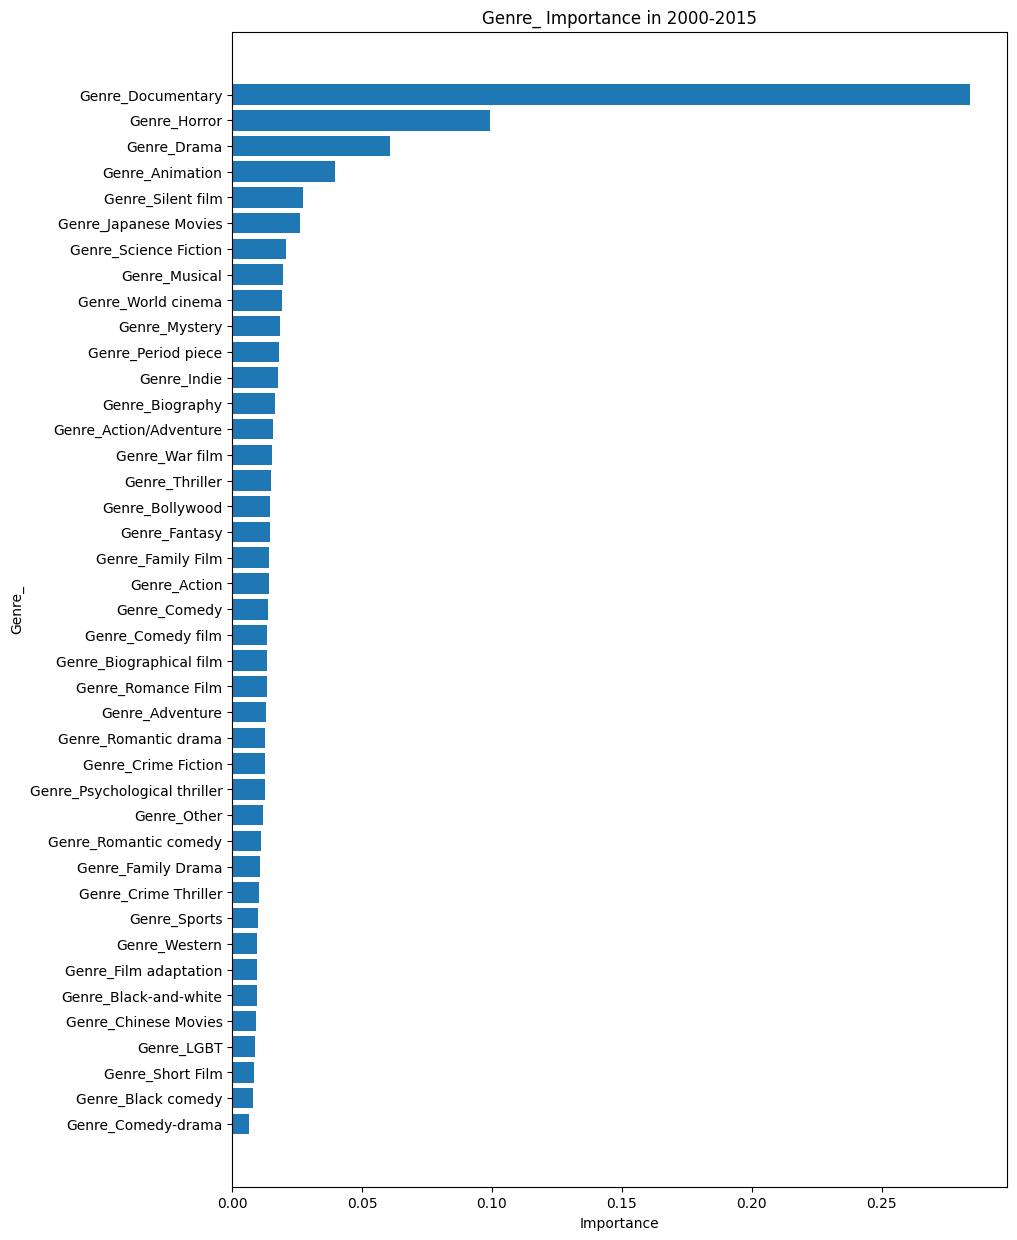

(23, 23)


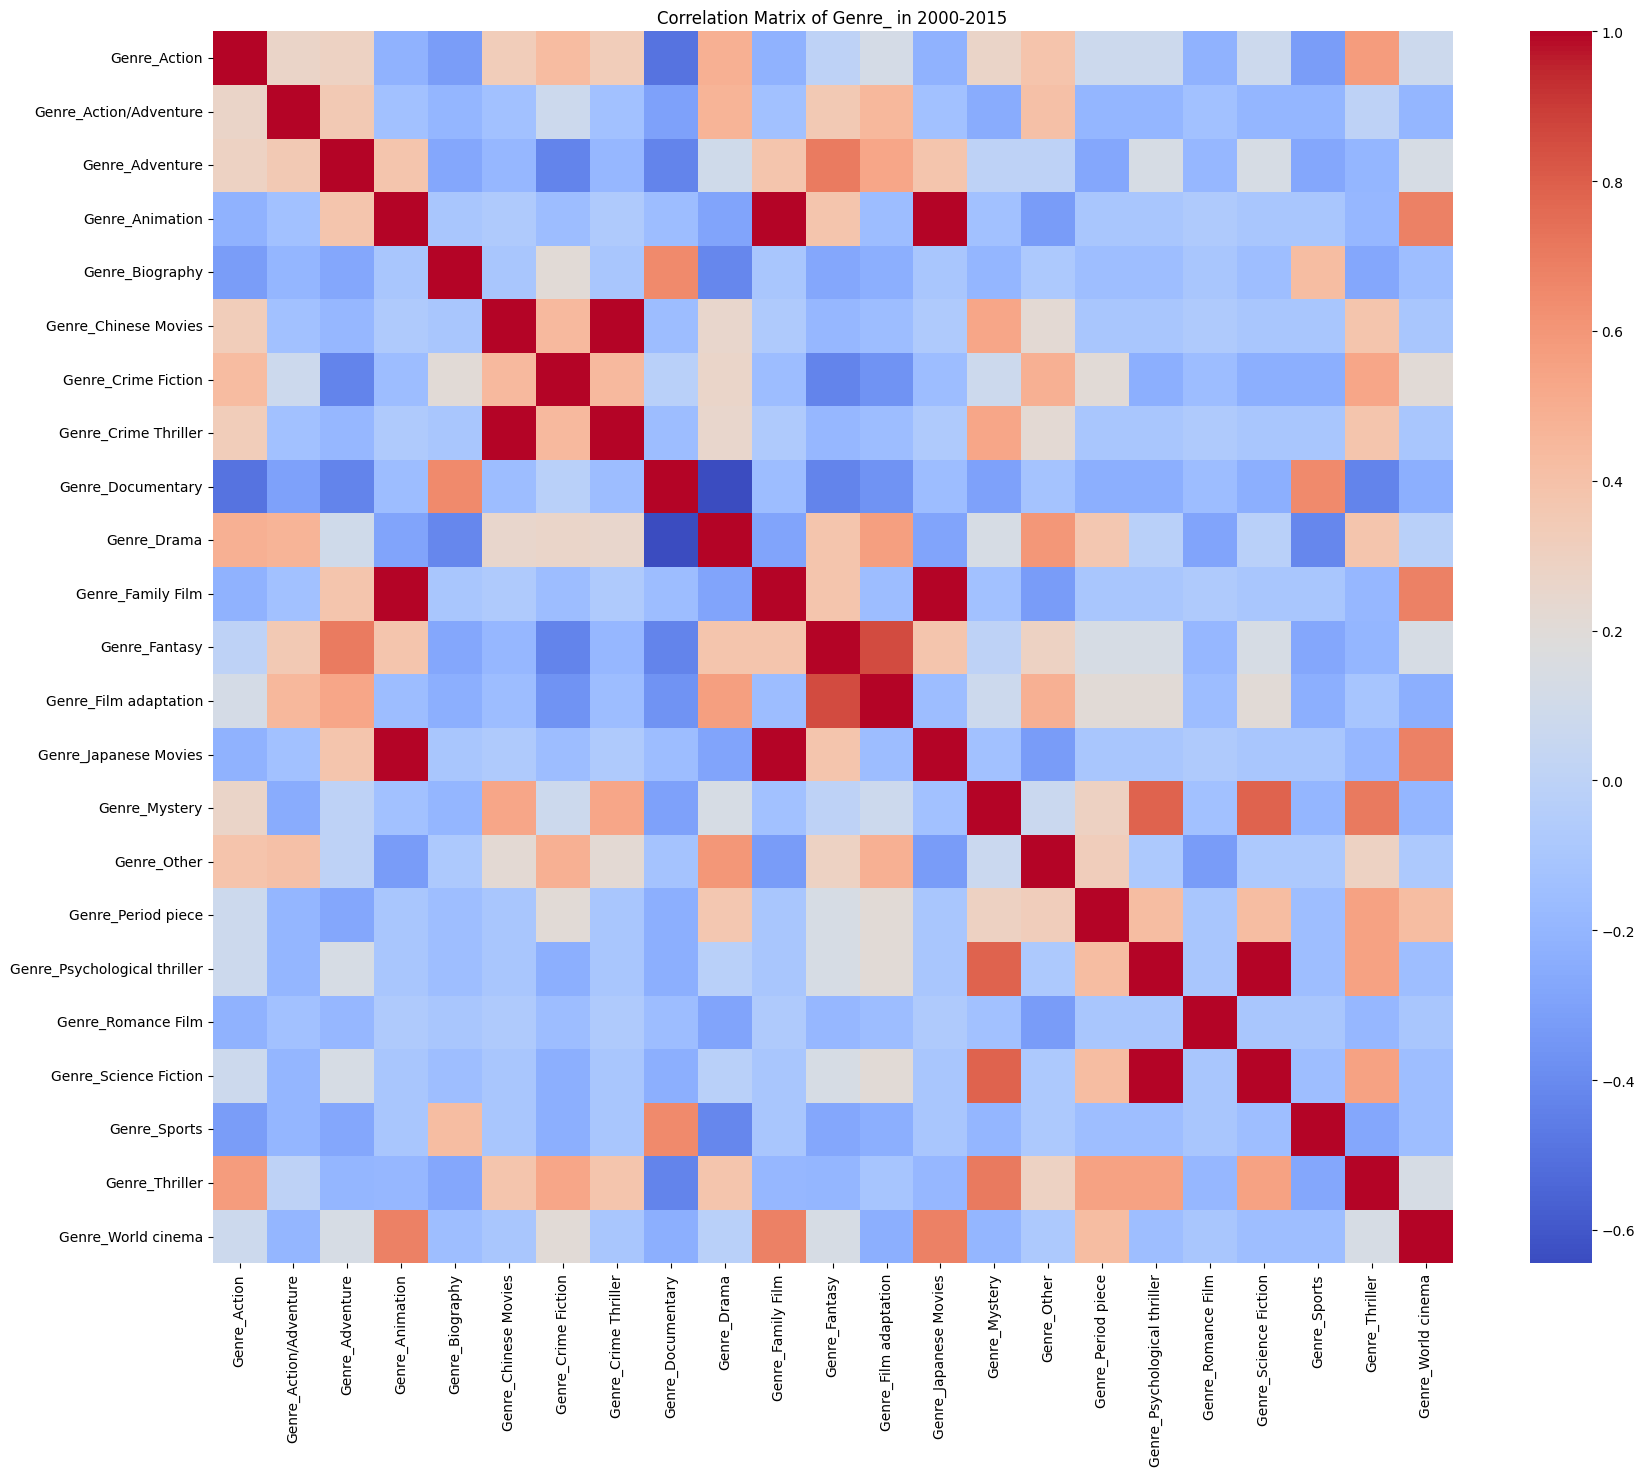

In [525]:
plot_feature_importance('2000-2015',df_period4,'Genre_')
corr_matrix_top_(periods[4],df_period4,"Genre_")

(7, 7)


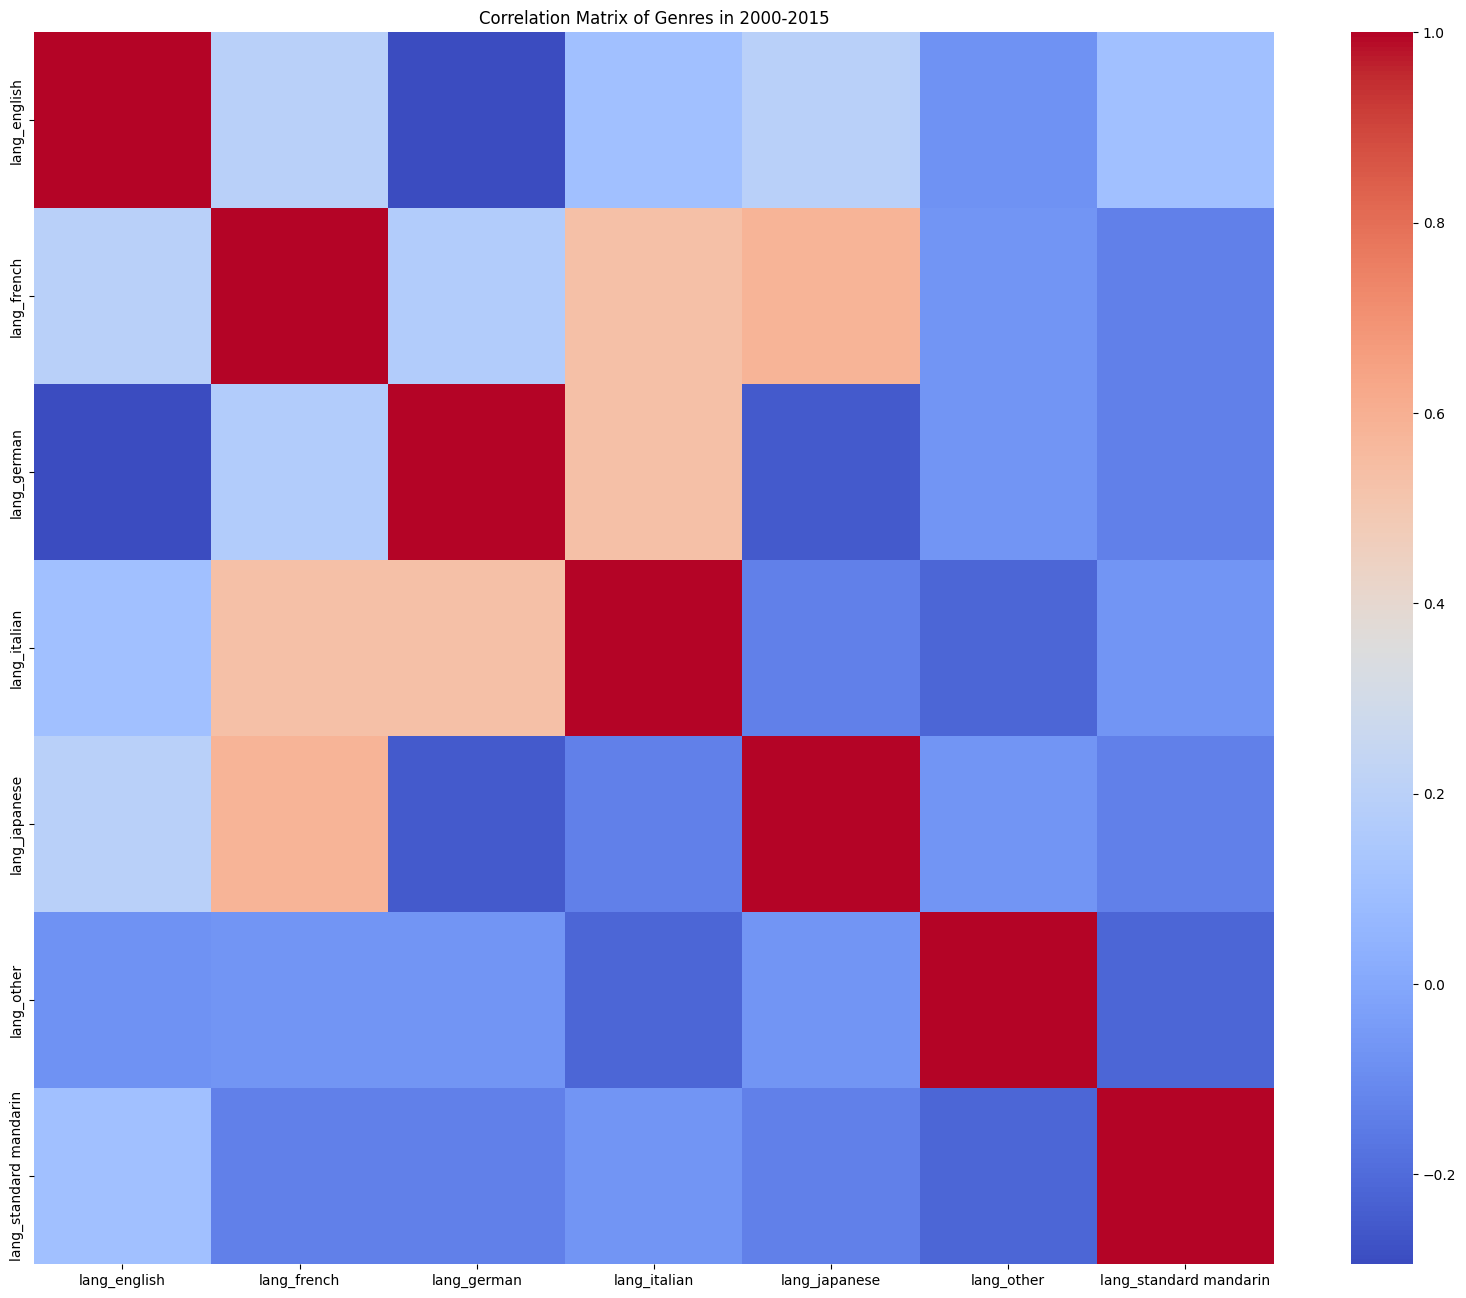

In [208]:
corr_matrix_top_(periods[4],df_period4,"lang_")

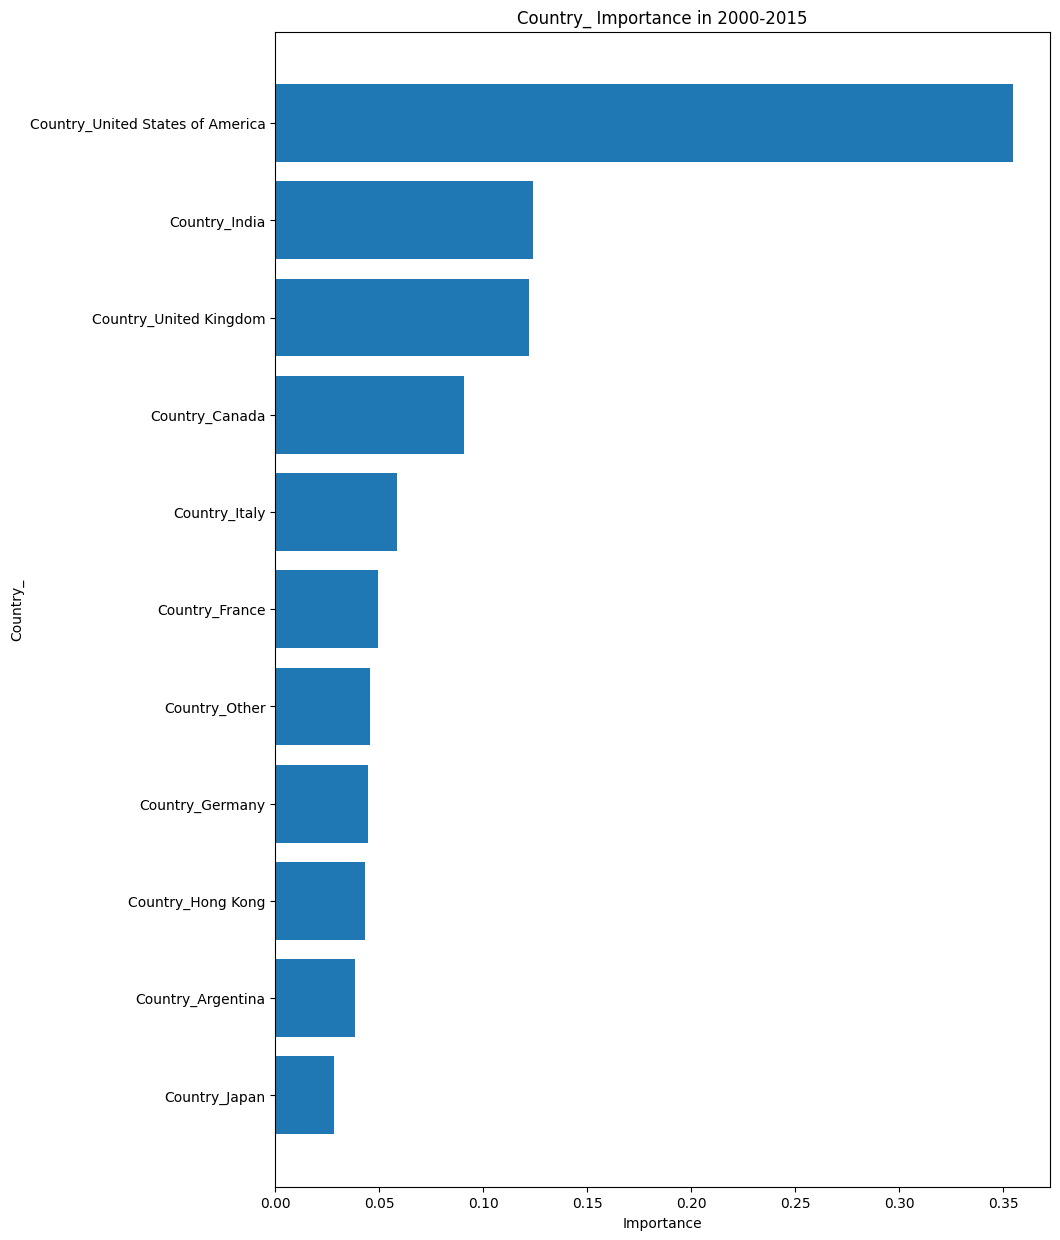

(6, 6)


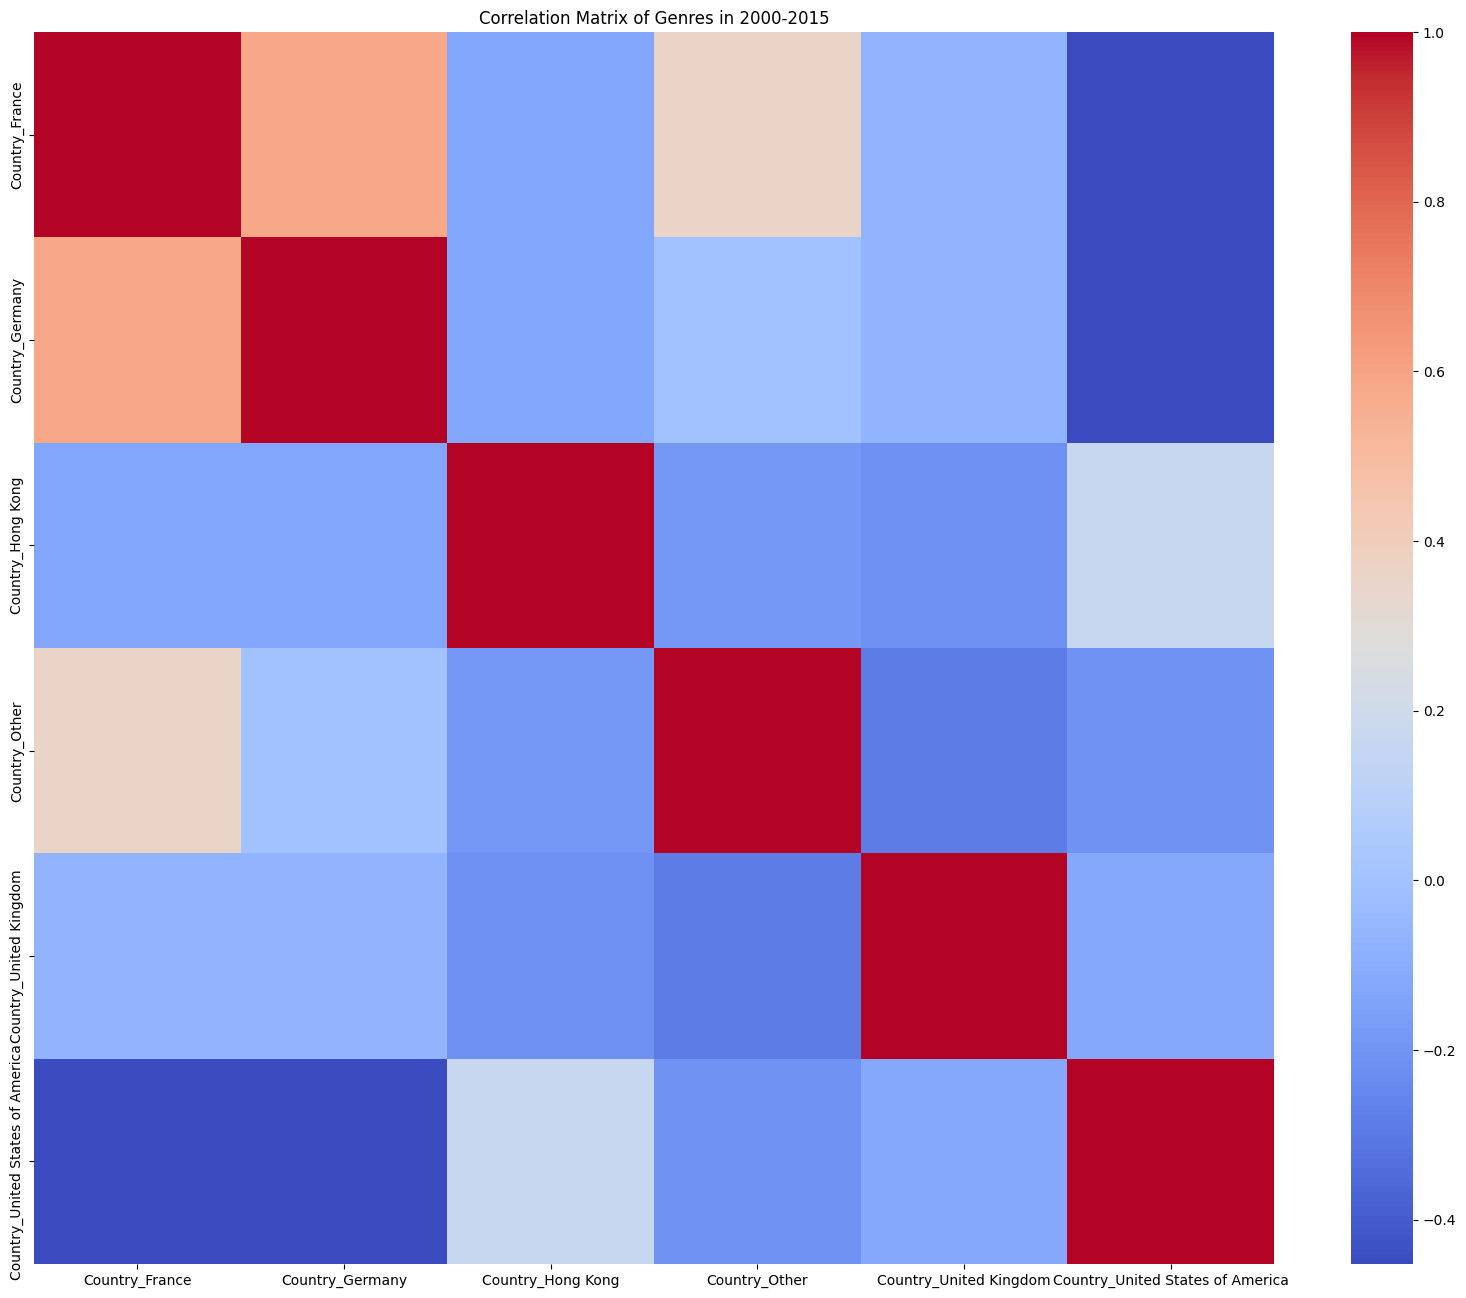

In [235]:
plot_feature_importance('2000-2015',df_period4,'Country_')
corr_matrix_top_(periods[4],df_period4,"Country_")